# Performance on real microscopic data

Here, we're using the model with labeled images of E.coli, kindly provided by Yundon


In [4]:
import os
from scipy.io import loadmat
import numpy as np
import PIL.Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from yundon_functions import YundonImage
import sys
sys.path.append("..")
from YOLOtrack11 import YOLOtrack11

%matplotlib widget

First, we'll have a look at the provided data:


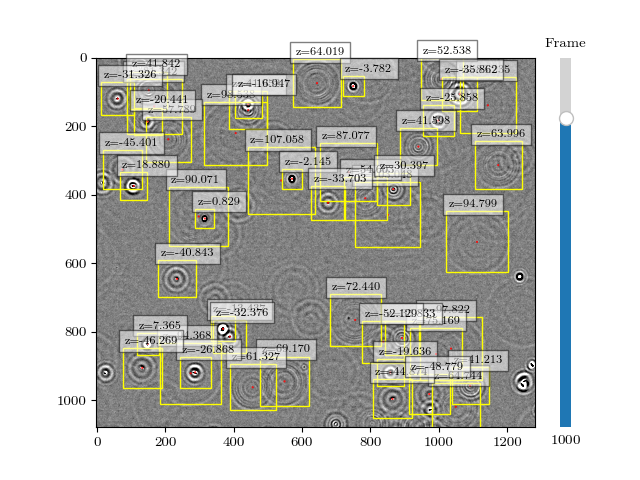

In [45]:
# Let' have a look at the data

image_set_path = "../datasets/Zstack_DownSampled_BGCorrected_TrackingData" # Path to the provided data
image_sets = [image_set_path+"/"+entry for entry in os.listdir(image_set_path) if entry.startswith("Image Set")]

image_set = image_sets[2] #choose which image set to look at
image = YundonImage(image_set)


plt.figure(1), plt.clf()
ax1=plt.subplot2grid((1,20), (0,0), colspan=19)
image.plot_gt(ax1, 1000)
ax2=plt.subplot2grid((1,20), (0,19), colspan=1)
sl = Slider(ax2, 'Frame', 0, 1195, valinit=1000, valstep=1, orientation="vertical")
def update(val):
    ax1.clear()
    image.plot_gt(ax1, int(sl.val))


sl.on_changed(update)
plt.show()


When reviewing the data, it seems that above a certain index, many particles are missing from the provided tracking results. (maybe because they don't pass through the focus).
Thus, we set a max index up to which we want to use the data. Additionally, particles close to the edge are missing from the data as well. Thus we take only the inner part of each image, creating an offset around the images to be discarded. For training, the height needs to be a multiple of 32, the size of the largest grid cells in the model.

In [27]:
max_index = 880
offset = 32*4 #offset multiple of 32, which is the max stride (= grid  cell size) of the YOLO network

First, we need to convert the data into the YOLO dataset format. We remove a border of 100 px around the original $1280\times1080\,\text{px}$ .

In [ ]:
image_set_path = "../datasets/Zstack_DownSampled_BGCorrected_TrackingData"
image_sets = [image_set_path+"/"+entry for entry in os.listdir(image_set_path) if entry.startswith("Image Set")]
image_sets.sort()
image_sets.pop() #remove last image set from list, it will be used for testing!

print("available img sets:", image_sets)

dataset_path = "../datasets/Dataset_yundon"
os.makedirs(dataset_path+"/images/train")
os.makedirs(dataset_path+"/images/val")
os.makedirs(dataset_path+"/labels/train")
os.makedirs(dataset_path+"/labels/val")
inner_slice = np.s_[offset:-offset, offset:-offset]
train_val_split = 0.95 # 5% of the image will land in the val folder
img_width = 1280 - 2*offset #width of the image after cropping
img_height = 1080 - 2*offset #height of the image after cropping
for set_number, image_set in enumerate(image_sets, start=1):
    files_in_img_set_folder = [entry for entry in os.listdir(image_set) if not entry.startswith(".")]
    tifs = [image_set+"/"+entry for entry in files_in_img_set_folder if entry.endswith(".tif")]
    tifs.sort()
    print(tifs)
    image_objects = [PIL.Image.open(tif) for tif in tifs]

    matfile = [image_set+"/"+entry for entry in files_in_img_set_folder if entry.endswith(".mat")][0]
    x,y,z0 = [v.astype(np.float32) for v in loadmat(matfile)['BugXYZPositionAmpFinal'].T[:3]]

    x = ((x/0.325)-offset)/img_width #normalize x and y to [0,1]
    y = ((y/0.325)-offset)/img_height

    # # with this mask, we later filter out the visible particles in each quadrant
    # quadrants_masks = [((y <  1) & (x <  1)), #top left ...
    #                   ((y <  1) & (x >= 1)),
    #                   ((y >= 1) & (x <  1)),
    #                   ((y >= 1) & (x >= 1))] # bottom right
    
    # # with these slices, we cut the image array into quadrants
    # quadrant_slices = [np.s_[:540,:640], #top left...
    #                    np.s_[:540,640:],
    #                    np.s_[540:,:640],
    #                    np.s_[540:,640:]] #bottom right
    
    # # make x,y relative to quadrant and [0,1]
    # x = x%1
    # y = y%1

    class_id = np.zeros_like(x) #make dummy class id (always 0)

    
    progress_bar = tqdm(range(max_index), desc=image_set)
    for z_level in progress_bar: # there are 1501 total z levels in each stack
        image_obj = image_objects[z_level//387]
        #set z and bounding box sizes for current z_level
        z = 0.2676 * z_level - z0
        bw = (np.abs(z)/0.161*0.21+55)
        bh = bw.copy()
        bw/=img_width
        bh/=img_height

        z_mask = (z > -110) & (z < 110)

        image_obj.seek(z_level % 387) #each image file has 387 frames
        image_array = np.array(image_obj).astype(np.uint16) #cast image to 16 bit int numpy array

        # for quadrant_number, (quadrant_mask, quadrant_slice) in enumerate(zip(quadrants_masks, quadrant_slices)): #go through the 4 quadrants
        id = f"set{set_number}_z{z_level}" #ID used in filenames

        mode = "val" if np.random.random()>train_val_split else "train"
        image_fname = dataset_path+f"/images/{mode}/"+id+".tif"
        label_fname = dataset_path+f"/labels/{mode}/"+id+".txt"

        sliced_array = image_array[inner_slice] #get current slice from image array

        with PIL.Image.fromarray(sliced_array) as sliced_img:
            sliced_img.save(image_fname, quality=100) #save current slice

        
        data = np.column_stack([class_id,x,y,bw,bh,z, x, y])[z_mask]

        np.savetxt(label_fname, data, fmt='%g')

    [img.close() for img in image_objects] #close images





/tmp/ipykernel_1797933/3941507574.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x,y,z0 = [v.astype(np.float32) for v in loadmat(matfile)['BugXYZPositionAmpFinal'].T[:3]]


available img sets: ['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 1 - 250319', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 2 - 250616', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 3 - 250616', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 4 - 250616', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 5 - 250616', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 6 - 250616', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 7 - 250616']
['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 1 - 250319/BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 1 - 250319/BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0_1.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 1 - 250319/BGC101_H2V2Z1_Ch1_zstack_1_MMStack_Pos0_2.ome.tif', '../datasets/Zstack_DownSample

../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 1 - 250319:   0%|          | 0/880 [00:00<?, ?it/s]

../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 1 - 250319: 100%|██████████| 880/880 [00:04<00:00, 176.43it/s]


['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 2 - 250616/BGC101_H2V2Z1_Ch1_zstack_2_MMStack_Pos0.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 2 - 250616/BGC101_H2V2Z1_Ch1_zstack_2_MMStack_Pos0_1.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 2 - 250616/BGC101_H2V2Z1_Ch1_zstack_2_MMStack_Pos0_2.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 2 - 250616/BGC101_H2V2Z1_Ch1_zstack_2_MMStack_Pos0_3.tif']


../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 2 - 250616: 100%|██████████| 880/880 [00:04<00:00, 177.76it/s]


['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 3 - 250616/BGC101_H2V2Z1_Ch1_zstack_3_MMStack_Pos0.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 3 - 250616/BGC101_H2V2Z1_Ch1_zstack_3_MMStack_Pos0_1.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 3 - 250616/BGC101_H2V2Z1_Ch1_zstack_3_MMStack_Pos0_2.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 3 - 250616/BGC101_H2V2Z1_Ch1_zstack_3_MMStack_Pos0_3.ome.tif']


../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 3 - 250616: 100%|██████████| 880/880 [00:05<00:00, 169.07it/s]


['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 4 - 250616/BGC101_H2V2Z1_Ch2_zstack_1_MMStack_Pos0.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 4 - 250616/BGC101_H2V2Z1_Ch2_zstack_1_MMStack_Pos0_1.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 4 - 250616/BGC101_H2V2Z1_Ch2_zstack_1_MMStack_Pos0_2.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 4 - 250616/BGC101_H2V2Z1_Ch2_zstack_1_MMStack_Pos0_3.ome.tif']


../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 4 - 250616: 100%|██████████| 880/880 [00:05<00:00, 174.63it/s]


['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 5 - 250616/BGC101_H2V2Z1_Ch3_zstack_1_MMStack_Pos0.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 5 - 250616/BGC101_H2V2Z1_Ch3_zstack_1_MMStack_Pos0_1.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 5 - 250616/BGC101_H2V2Z1_Ch3_zstack_1_MMStack_Pos0_2.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 5 - 250616/BGC101_H2V2Z1_Ch3_zstack_1_MMStack_Pos0_3.ome.tif']


../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 5 - 250616: 100%|██████████| 880/880 [00:05<00:00, 170.32it/s]


['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 6 - 250616/BGC101_H2V2Z1_Ch3_zstack_2_MMStack_Pos0.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 6 - 250616/BGC101_H2V2Z1_Ch3_zstack_2_MMStack_Pos0_1.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 6 - 250616/BGC101_H2V2Z1_Ch3_zstack_2_MMStack_Pos0_2.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 6 - 250616/BGC101_H2V2Z1_Ch3_zstack_2_MMStack_Pos0_3.ome.tif']


../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 6 - 250616: 100%|██████████| 880/880 [00:05<00:00, 175.43it/s]


['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 7 - 250616/BGC101_H2V2Z1_Ch3_zstack_3_MMStack_Pos0.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 7 - 250616/BGC101_H2V2Z1_Ch3_zstack_3_MMStack_Pos0_1.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 7 - 250616/BGC101_H2V2Z1_Ch3_zstack_3_MMStack_Pos0_2.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 7 - 250616/BGC101_H2V2Z1_Ch3_zstack_3_MMStack_Pos0_3.ome.tif']


../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 7 - 250616: 100%|██████████| 880/880 [00:05<00:00, 169.22it/s]


Next, we take the remaining Image set and save the labels as well.

In [30]:
image_set_path = "../datasets/Zstack_DownSampled_BGCorrected_TrackingData"
image_sets = [image_set_path+"/"+entry for entry in os.listdir(image_set_path) if entry.startswith("Image Set")]
image_sets.sort()
image_sets = image_sets[-1:] #use only the last image set for testing

print("available img sets:", image_sets)

dataset_path = "../datasets/Dataset_yundon"
os.makedirs(dataset_path+"/labels/test",exist_ok=True)
os.makedirs(dataset_path+"/images/test",exist_ok=True)
inner_slice = np.s_[offset:-offset, offset:-offset]
img_width = 1280 - 2*offset #width of the image after cropping
img_height = 1080 - 2*offset #height of the image after cropping
for set_number, image_set in enumerate(image_sets, start=1):
    files_in_img_set_folder = [entry for entry in os.listdir(image_set) if not entry.startswith(".")]
    tifs = [image_set+"/"+entry for entry in files_in_img_set_folder if entry.endswith(".tif")]
    tifs.sort()
    print(tifs)
    image_objects = [PIL.Image.open(tif) for tif in tifs]

    matfile = [image_set+"/"+entry for entry in files_in_img_set_folder if entry.endswith(".mat")][0]
    x,y,z0 = [v.astype(np.float32) for v in loadmat(matfile)['BugXYZPositionAmpFinal'].T[:3]]

    x = ((x/0.325)-offset)/img_width #normalize x and y to [0,1]
    y = ((y/0.325)-offset)/img_height

    # # with this mask, we later filter out the visible particles in each quadrant
    # quadrants_masks = [((y <  1) & (x <  1)), #top left ...
    #                   ((y <  1) & (x >= 1)),
    #                   ((y >= 1) & (x <  1)),
    #                   ((y >= 1) & (x >= 1))] # bottom right
    
    # # with these slices, we cut the image array into quadrants
    # quadrant_slices = [np.s_[:540,:640], #top left...
    #                    np.s_[:540,640:],
    #                    np.s_[540:,:640],
    #                    np.s_[540:,640:]] #bottom right
    
    # # make x,y relative to quadrant and [0,1]
    # x = x%1
    # y = y%1

    class_id = np.zeros_like(x) #make dummy class id (always 0)

    
    progress_bar = tqdm(range(max_index), desc=image_set)
    for z_level in progress_bar: # there are 1501 total z levels in each stack
        image_obj = image_objects[z_level//387]
        #set z and bounding box sizes for current z_level
        z = 0.2676 * z_level - z0
        bw = (np.abs(z)/0.161*0.21+55)
        bh = bw.copy()
        bw/=img_width
        bh/=img_height

        z_mask = (z > -110) & (z < 110)

        image_obj.seek(z_level % 387) #each image file has 387 frames
        image_array = np.array(image_obj).astype(np.uint16) #cast image to 16 bit int numpy array

        # for quadrant_number, (quadrant_mask, quadrant_slice) in enumerate(zip(quadrants_masks, quadrant_slices)): #go through the 4 quadrants
        id = f"set{set_number}_z{z_level}" #ID used in filenames

        mode = "test"
        image_fname = dataset_path+f"/images/{mode}/"+id+".tif"
        label_fname = dataset_path+f"/labels/{mode}/"+id+".txt"

        sliced_array = image_array[inner_slice] #get current slice from image array

        with PIL.Image.fromarray(sliced_array) as sliced_img:
            sliced_img.save(image_fname, quality=100) #save current slice

        
        data = np.column_stack([class_id,x,y,bw,bh,z, x, y])[z_mask]

        np.savetxt(label_fname, data, fmt='%g')

    [img.close() for img in image_objects] #close images




/tmp/ipykernel_2710480/705568474.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x,y,z0 = [v.astype(np.float32) for v in loadmat(matfile)['BugXYZPositionAmpFinal'].T[:3]]


available img sets: ['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616']
['../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616/BGC101_H2V2Z1_Ch3_zstack_4_MMStack_Pos0.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616/BGC101_H2V2Z1_Ch3_zstack_4_MMStack_Pos0_1.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616/BGC101_H2V2Z1_Ch3_zstack_4_MMStack_Pos0_2.ome.tif', '../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616/BGC101_H2V2Z1_Ch3_zstack_4_MMStack_Pos0_3.ome.tif']


../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616:   0%|          | 0/880 [00:00<?, ?it/s]

../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616: 100%|██████████| 880/880 [00:03<00:00, 225.76it/s]


Next, we need a .yaml file for training

In [ ]:
import yaml
subdir = '../datasets/Dataset_yundon/'

file_path = '../datasets/yundon.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val"
dict["test"]=os.getcwd() + '/' + subdir + "images/" + "test"
dict["kpt_shape"] = [1,2]
dict["num_extra_parameters"] = 1
dict["extra_param_names"] = ["z"]
dict['nc'] = 1
dict['names'] = ["Ripple"]

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)

Let's first train the model on the real data only!

In [ ]:
model = YOLOtrack11("yolo11n-zaxis.yaml")
results = model.train(data="datasets/yundon.yaml",epochs=50, workers=0, imgsz=1024)
model.save("yolo11n-yundon.pt")

New https://pypi.org/project/ultralytics/8.3.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
trainer: task=zaxis, mode=train, model=yolo11n-zaxis.yaml, data=datasets/yundon.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train274, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/train... 10494 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10494/10494 [00:15<00:00, 658.28it/s]


train: New cache created: /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/train.cache


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/val... 1314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1314/1314 [00:01<00:00, 663.78it/s]

val: New cache created: /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/val.cache
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.


optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 93 weight(decay=0.0), 106 weight(decay=0.0005), 105 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to /home/jupyter-till/git/ultralytics/runs/zaxis/train274
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       1/50        17G      2.778      2.948      3.908      235.4      13.89          0        758       1024: 100%|██████████| 656/656 [01:54<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]


                   all       1314      70713     0.0493      0.275     0.0321      0.011       70.2       10.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       2/50      11.5G      2.759      2.619      3.479      199.6      12.15          0        937       1024:  68%|██████▊   | 448/656 [01:17<00:36,  5.77it/s]


KeyboardInterrupt: 

Now, we'll test it:

In [54]:
import sys
import numpy as np
import os
sys.path.append("..")
from YOLOtrack11 import YOLOtrack11
# model = YOLOtrack11("yolo11n-yundon.pt")
model = YOLOtrack11("../../ultralytics/runs/zaxis/train284/weights/last.pt")
# print(model.model.model)
print("loaded")
dataset_path = "../datasets/Dataset_yundon/images/test"
# dataset_path = "../ultralytics/data_gen/Dataset_hard/images/val"
imgsz=1024,824
# imgsz=640,540
test_images = os.listdir(dataset_path)
random_image = lambda: dataset_path+"/"+test_images[np.random.randint(0,len(test_images))]

loaded


In [56]:
from itertools import repeat
from matplotlib.patches import Rectangle, Circle
import PIL.Image
def plot_gt(path,ax,imgsz=[512,512],vmin=1.95e4,vmax=2.05e4):
    data=np.atleast_2d(np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt"))).T
    # print(data)
    if(len(data)==0):
         return plot_result(ax,path, np.empty(0),np.empty((0,4)),np.empty(0),np.empty((0,0)),vmin=vmin,vmax=vmax)
    cls = data[0]
    bboxes = data[1:5].T*(imgsz*2)
    bboxes[:,2:]=bboxes[:,2:]
    z = data[5]
    kpts = data[6:].T*imgsz
    # print(bboxes)
    
    return plot_result(ax,path, cls,bboxes,z,kpts, vmin=vmin,vmax=vmax)
def plot_result(ax,img,cls,bboxes=repeat(None),z=None,kpts=None, conf=None,vmin=1.95e4,vmax=2.05e4):
    is_conf = conf is not None
    if not is_conf:
         conf = np.zeros_like(cls)
    if isinstance(img, PIL.Image.Image):
        pass
    elif(type(img) == str):
        img = PIL.Image.open(img)
    print(vmin,vmax)
    ax.imshow(img,cmap="grey",vmin=vmin,vmax=vmax)
    ax.axis("off")
    for bbox,z_value,kpt,c in zip(bboxes,z, kpts,conf):
        if(bbox is not None):
            x,y,w,h = bbox
            rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
            tx,ty = rect.get_xy()
            ax.add_patch(rect)
            tx+=6
            ty-=12
        else:
            tx,ty = kpt
            ty-=40
            tx-=50
        circle = Circle(kpt,1, facecolor="red",edgecolor="red")
        ax.add_patch(circle)
        ax.text(tx,ty,f"z={z_value:.3f}" + (f", {c*100:.0f}%" if is_conf else ""),fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))

    return bboxes,z


image 1/1 /home/jupyter-till/git/YOLOTrack11/notebooks/../datasets/Dataset_yundon/images/test/set1_z531.tif: 832x1024 45 Ripples, 7.7ms
Speed: 9.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 832, 1024)
19500.0 20500.0


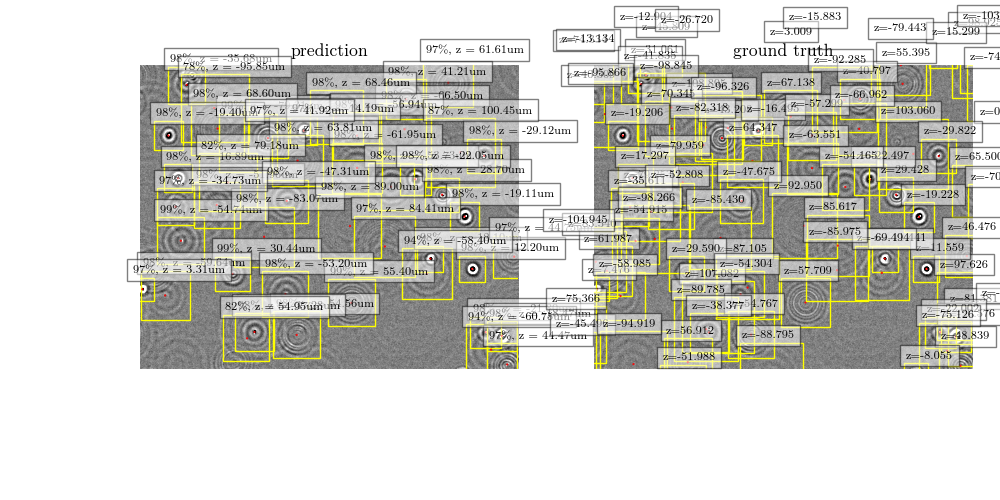

In [57]:
import matplotlib.pyplot as plt
%matplotlib widget
img = random_image()
res = model.predict(img, conf=0.2, background=2e4)
fig=plt.figure(2)
plt.clf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.subplot(121)
plt.title("prediction")
res[0].plot(plt.gca(),vmin=1.95e4, vmax=2.05e4)
plt.axis("off")
plt.subplot(122)
plt.title("ground truth")
plot_gt(img, plt.gca(), (1024,824))
# plt.axis("on")
plt.show()

How do we get the model to be more effective on the data? Since we only have a small amount of real data, one approach is **fine tuning** a model that was trained on generated data, i.e. re-training it with a smaller learning rate on bacteria dataset

First, we try fine tuning all weights in the model:

In [14]:
pretrained_model = YOLOtrack11("yolo11n-ripples256.pt")
pretrained_model.train(data="../datasets/yundon.yaml",lr0=0.0001, warmup_epochs=0, epochs=10, workers=0)
pretrained_model.save("yolo11n-yundon_pretrained.pt")

New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
trainer: task=zaxis, mode=train, model=yolo11n-ripples256.pt, data=../datasets/yundon.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train303, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/train.cache... 5822 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5822/5822 [00:00<?, ?it/s]
val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/val.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]

WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 93 weight(decay=0.0), 106 weight(decay=0.0005), 105 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to /home/jupyter-till/git/ultralytics/runs/zaxis/train303
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size



       1/10      13.2G      1.316     0.9723       2.94      27.32       3.45          0        903       1024: 100%|██████████| 364/364 [00:59<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.28it/s]

                   all        338      23198       0.76      0.631      0.781      0.565       10.5       2.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       2/10      14.2G     0.9052      0.775      1.745      15.27      2.542          0        961       1024: 100%|██████████| 364/364 [00:57<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.93it/s]

                   all        338      23198       0.87      0.715      0.803      0.664       7.38       2.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       3/10      13.6G     0.7087     0.6972       1.41      11.19      2.095          0        988       1024: 100%|██████████| 364/364 [00:56<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.94it/s]

                   all        338      23198       0.89      0.722      0.815      0.714       6.36       2.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       4/10      14.1G     0.6267     0.6504      1.298      8.936      1.806          0        902       1024: 100%|██████████| 364/364 [00:56<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.92it/s]

                   all        338      23198      0.896      0.724      0.821      0.738       5.67       2.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       5/10      14.8G      0.579     0.6201      1.243      7.538      1.623          0        873       1024: 100%|██████████| 364/364 [00:56<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

                   all        338      23198        0.9      0.728      0.829      0.754       5.23       2.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       6/10      13.7G     0.5521     0.5988      1.215        6.6       1.52          0        901       1024: 100%|██████████| 364/364 [00:56<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.97it/s]

                   all        338      23198      0.903      0.731      0.835      0.765       5.04          3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       7/10      14.1G     0.5372     0.5851      1.199       5.91      1.456          0        953       1024: 100%|██████████| 364/364 [00:56<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.96it/s]

                   all        338      23198      0.906      0.729      0.836      0.767       5.36       2.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       8/10      15.1G      0.528     0.5746       1.19      5.471      1.412          0        890       1024: 100%|██████████| 364/364 [00:56<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.90it/s]

                   all        338      23198      0.904       0.73      0.834      0.765        5.2       2.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       9/10      13.6G     0.5223     0.5674      1.184       5.15      1.384          0        922       1024: 100%|██████████| 364/364 [00:56<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.93it/s]

                   all        338      23198      0.906      0.734      0.841      0.774       5.17          3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


      10/10      12.9G     0.5191     0.5635      1.181      4.984      1.369          0        957       1024: 100%|██████████| 364/364 [00:56<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:02<00:00,  4.94it/s]

                   all        338      23198      0.906      0.732       0.84      0.773       5.09       2.92



10 epochs completed in 0.165 hours.
Optimizer stripped from /home/jupyter-till/git/ultralytics/runs/zaxis/train303/weights/last.pt, 5.9MB
Optimizer stripped from /home/jupyter-till/git/ultralytics/runs/zaxis/train303/weights/best.pt, 5.9MB

Validating /home/jupyter-till/git/ultralytics/runs/zaxis/train303/weights/best.pt...
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,252 parameters, 0 gradients, 6.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 11/11 [00:01<00:00,  6.06it/s]

                   all        338      23198      0.906      0.732       0.84      0.773       5.04       2.92
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.2ms postprocess per image


Let's test the fine-tuned model as well:


image 1/1 /home/jupyter-till/git/YOLOTrack11/notebooks/../datasets/Dataset_yundon/images/test/set1_z346.tif: 832x1024 70 Ripples, 2.7ms
Speed: 0.3ms preprocess, 2.7ms inference, 0.5ms postprocess per image at shape (1, 3, 832, 1024)
19500.0 20500.0


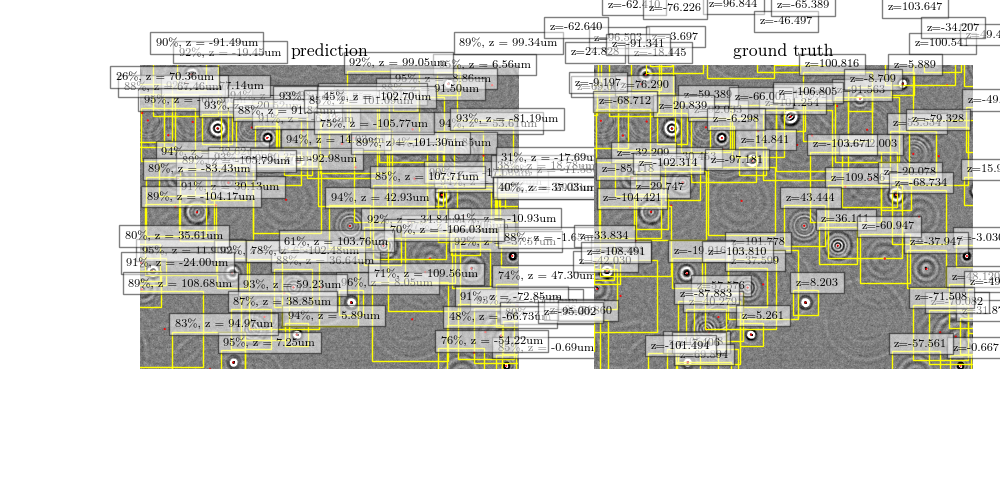

In [60]:
img = random_image()
finetuned_model = YOLOtrack11("yolo11n-yundon_pretrained.pt")
res = finetuned_model.predict(img, conf=0.2, background=2e4)
fig=plt.figure(2)
plt.clf()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.subplot(121)
plt.title("prediction")
res[0].plot(plt.gca(),vmin=1.95e4, vmax=2.05e4)
plt.axis("off")
plt.subplot(122)
plt.title("ground truth")
plot_gt(img, plt.gca(), (1024,824))
# plt.axis("on")
plt.show()

Let's evaluate the models

In [ ]:
results = []
models = [YOLOtrack11("yolo11n-yundon.pt"), YOLOtrack11("yolo11n-yundon_pretrained.pt")]

for m in models:
    results.append(m.val(data="../datasets/yundon.yaml", workers=0, imgsz=[1024], conf=0.7, split="test"))
visible = [(res.xyz_pairs[:,0,0] >= 0) & (res.xyz_pairs[:,0,0] < 1024) & (res.xyz_pairs[:,0,1] >= 0) & (res.xyz_pairs[:,0,1] < 824) for res in results]

Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,252 parameters, 0 gradients, 6.7 GFLOPs
image size: 1024


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/test.cache... 1760 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1760/1760 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 110/110 [00:08<00:00, 13.74it/s]

                   all       1760     126980      0.936      0.582      0.789      0.749       3.42       2.32
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)


YOLO11n-zaxis summary (fused): 118 layers, 2,725,252 parameters, 0 gradients, 6.7 GFLOPs
image size: 1024


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_yundon/labels/test.cache... 1760 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1760/1760 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 110/110 [00:08<00:00, 13.74it/s]

                   all       1760     126980      0.903      0.679      0.833       0.78       2.77       2.57
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image


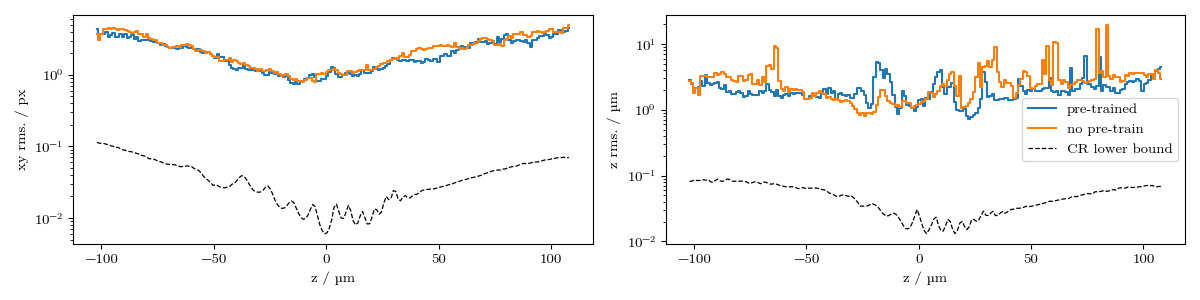

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
plt.figure(figsize=(12,3))
plt.subplot(121)
 
crlb = np.load("crlb_results.npz")
bins= 200
z = np.linspace(-102,108,bins)
bins_=np.linspace(-102,108,bins+1)
crlb_xy = np.interp(z, crlb["z_space"], crlb["std_xy"])
k=10
crlb_z = np.interp(z, crlb["z_space"][k//2:-k//2:k], np.convolve(crlb["std_z"], np.ones(k)/k, mode='same')[k//2:-k//2:k])
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2][visible[1]], results[1].xy_distances[visible[1]]**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2][visible[0]], results[0].xy_distances[visible[0]]**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), where="mid")
# plt.hist(results[0].xyz_pairs[:,0,2], bins=bins_)
plt.plot(z, crlb_xy, "--", c="k", lw=0.9)
plt.yscale("log")
plt.xlabel("z / µm")
plt.ylabel("xy rms. / px")

plt.subplot(122)
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2][visible[1]], np.subtract(*results[1].xyz_pairs[:,:,2][visible[1]].T)**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), label="pre-trained", where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2][visible[0]], np.subtract(*results[0].xyz_pairs[:,:,2][visible[0]].T)**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), label="no pre-train", where="mid")
k=10
plt.plot(z,crlb_z, "--", c="k", lw=0.9, label="CR lower bound")
plt.yscale("log")
plt.xlabel("z / µm")
plt.ylabel("z rms. / µm")
plt.legend()
# plt.ylim(0,7.5)
plt.tight_layout()

(145813,) (145813,)


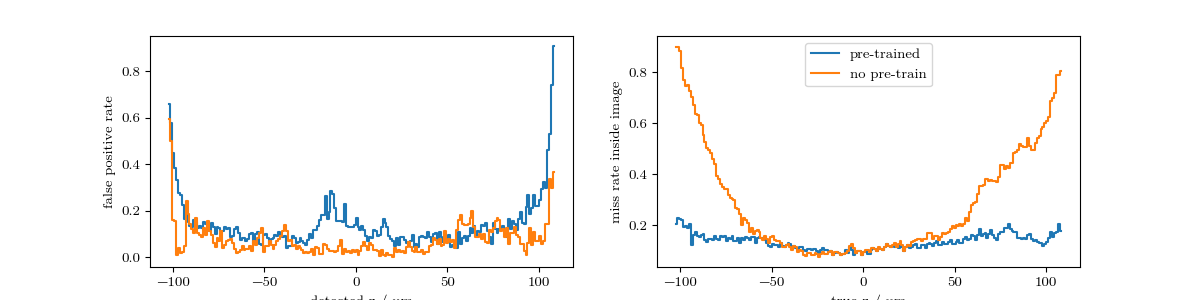

In [69]:
bins= 200
z = np.linspace(-102,108,bins)
bins_=np.linspace(-102,108,bins+1)

plt.figure(figsize=(12,3))
plt.subplot(121)
print((results[1].xyz_pairs[:,1,2].shape), (results[1].fp.shape))
y, x,_ = binned_statistic(results[1].xyz_pairs[:,1,2], results[1].fp, bins=bins_)
plt.step(z,y, where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,1,2], results[0].fp, bins=bins_)
plt.step(z,y, where="mid")
plt.xlabel("detected z / µm")
plt.ylabel("false positive rate")
plt.subplot(122)

y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2][visible[1]], results[1].fn[visible[1]], bins=bins_)
plt.step(z,y, where="mid", label="pre-trained")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2][visible[0]], results[0].fn[visible[0]], bins=bins_)
plt.step(z,y, where="mid", label="no pre-train")
plt.xlabel("true z / µm")
plt.ylabel("miss rate inside image")
plt.legend()

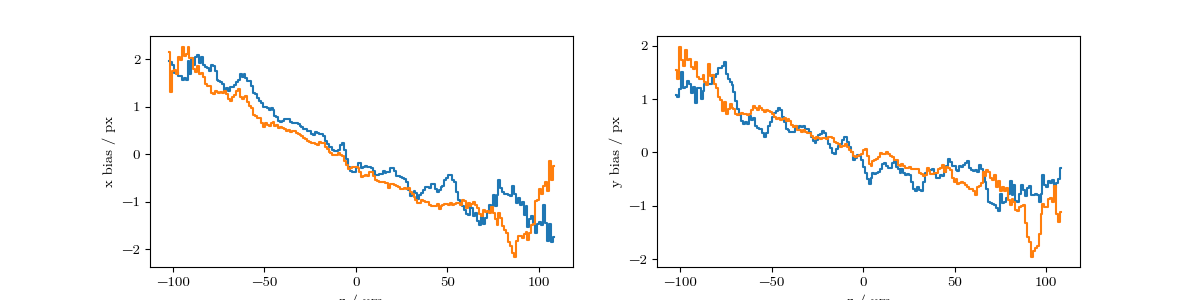

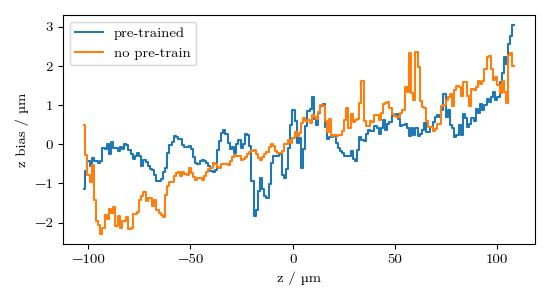

In [ ]:
bins= 200
z = np.linspace(-102,108,bins)
bins_=np.linspace(-102,108,bins+1)
plt.figure(figsize=(12,3))
plt.subplot(121)
z = np.linspace(-102,108,bins)
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2][visible[1]], np.subtract(*results[1].xyz_pairs[:,:,0][visible[1]].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2][visible[0]], np.subtract(*results[0].xyz_pairs[:,:,0][visible[0]].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid")
plt.xlabel("z / µm")
plt.ylabel("x bias / px")
plt.subplot(122)

y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2][visible[1]], np.subtract(*results[1].xyz_pairs[:,:,1][visible[1]].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid", label="with overlap")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2][visible[0]], np.subtract(*results[0].xyz_pairs[:,:,1][visible[0]].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid", label="with overlap")
# plt.hist(res.z_pairs[6][0], bins=bins_, statistic=np.nanmean)
plt.xlabel("z / µm")
plt.ylabel("y bias / px")

plt.figure(figsize=(5.5,3))
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2][visible[1]], np.subtract(*results[1].xyz_pairs[:,:,2][visible[1]].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, label="pre-trained", where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2][visible[0]], np.subtract(*results[0].xyz_pairs[:,:,2][visible[0]].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, label="no pre-train", where="mid")
plt.xlabel("z / µm")
plt.ylabel("z bias / µm")
plt.legend()
plt.tight_layout()

Let's also plot the true vs predicted x,y,z:

/tmp/ipykernel_2747143/3510327321.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


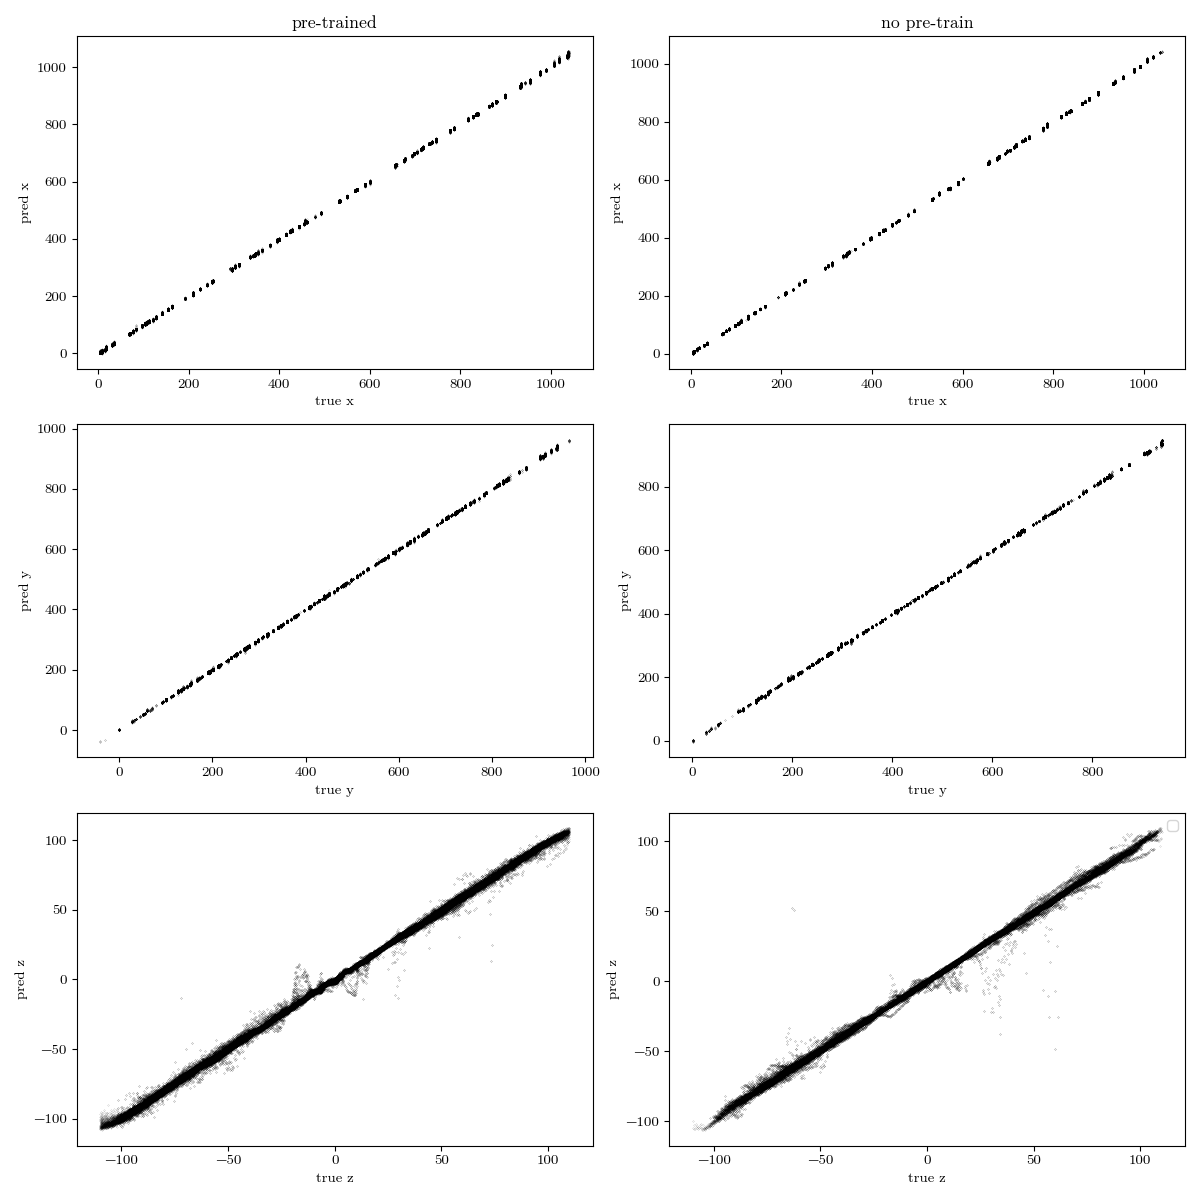

In [53]:
bins=300
plt.figure(figsize=(12,12))
plt.subplot(321)
plt.title("pre-trained")
plt.plot(results[1].xyz_pairs[:,0,0],results[1].xyz_pairs[:,1,0],"k.",ms=0.2, alpha=0.7)
plt.xlabel("true x")
plt.ylabel("pred x")

plt.subplot(322)
plt.title("no pre-train")
plt.plot(results[0].xyz_pairs[:,0,0],results[0].xyz_pairs[:,1,0],"k.",ms=0.2, alpha=0.7)
plt.xlabel("true x")
plt.ylabel("pred x")

plt.subplot(323)
plt.plot(results[1].xyz_pairs[:,0,1],results[1].xyz_pairs[:,1,1],"k.",ms=0.2, alpha=0.7)
plt.xlabel("true y")
plt.ylabel("pred y")

plt.subplot(324)
plt.plot(results[0].xyz_pairs[:,0,1],results[0].xyz_pairs[:,1,1],"k.",ms=0.2, alpha=0.7)
plt.xlabel("true y")
plt.ylabel("pred y")

plt.subplot(325)
plt.plot(results[1].xyz_pairs[:,0,2],results[1].xyz_pairs[:,1,2],"k.",ms=0.2, alpha=0.7)
plt.xlabel("true z")
plt.ylabel("pred z")

plt.subplot(326)
plt.plot(results[0].xyz_pairs[:,0,2],results[0].xyz_pairs[:,1,2],"k.",ms=0.2, alpha=0.7)
plt.xlabel("true z")
plt.ylabel("pred z")


plt.legend()
plt.tight_layout()

Let's finally plot the results from the full Image Set 8:

In [ ]:
from yundon_functions import YundonImage
import pandas as pd
set8 = YundonImage("../datasets/Zstack_DownSampled_BGCorrected_TrackingData/Image Set 8 - 250616")
pretrained_model = YOLOtrack11("yolo11n-yundon_pretrained.pt")
set8_results = []
for i in range(1196):
    set8_results.append(pretrained_model.predict(np.array(set8[i]))[0].to_df())
    
set8_results = pd.concat(set8_results, ignore_index=True)



0: 864x1024 94 Ripples, 2.9ms
Speed: 1.0ms preprocess, 2.9ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 864x1024 95 Ripples, 3.1ms
Speed: 0.9ms preprocess, 3.1ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 864x1024 102 Ripples, 3.1ms
Speed: 0.8ms preprocess, 3.1ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 864x1024 93 Ripples, 3.4ms
Speed: 1.1ms preprocess, 3.4ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 864x1024 97 Ripples, 3.2ms
Speed: 1.1ms preprocess, 3.2ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 864x1024 92 Ripples, 3.1ms
Speed: 0.9ms preprocess, 3.1ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 864x1024 93 Ripples, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 0.5ms postprocess per image at shape (1, 3, 864, 1024)

0: 864x1024 90 Ripples, 3.2ms
Speed: 0.9ms preprocess, 3.2ms inference, 0.5ms postprocess per image at

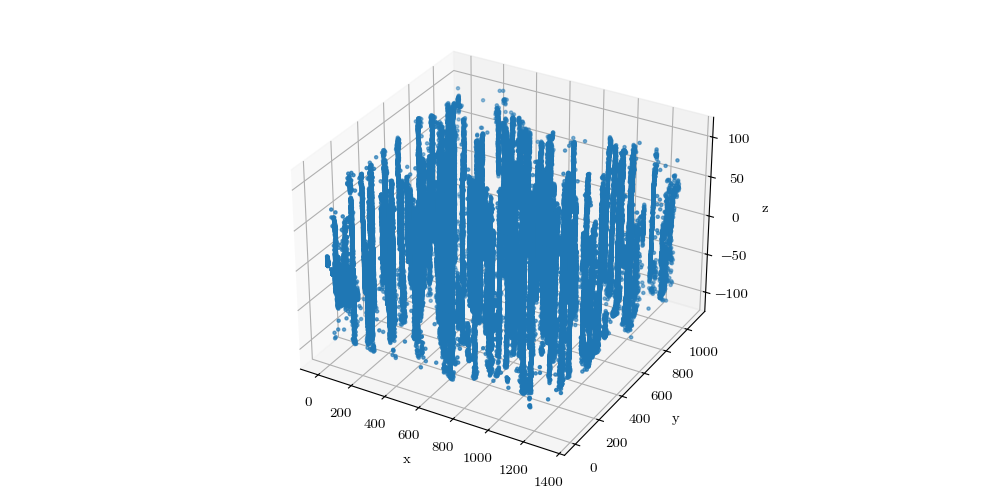

In [72]:
x = [s["x"] for s in set8_results["keypoints"]]
y = [s["y"] for s in set8_results["keypoints"]]
z = [s["z"] for s in set8_results["z"]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, marker=".")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()

plt.show()